In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import sys
sys.path.append('..')

In [142]:
from utils.data_storage import DataStorageReader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA

In [143]:
def rt_matrix(x=0, y=0, z=0, roll=0, pitch=0, yaw=0):
    c_y = np.cos(np.radians(yaw))
    s_y = np.sin(np.radians(yaw))
    c_r = np.cos(np.radians(roll))
    s_r = np.sin(np.radians(roll))
    c_p = np.cos(np.radians(pitch))
    s_p = np.sin(np.radians(pitch))
    matrix = np.matrix(np.identity(4))
    matrix[0, 3] = x
    matrix[1, 3] = y
    matrix[2, 3] = z
    matrix[0, 0] = c_p * c_y
    matrix[0, 1] = c_y * s_p * s_r - s_y * c_r
    matrix[0, 2] = -c_y * s_p * c_r - s_y * s_r
    matrix[1, 0] = s_y * c_p
    matrix[1, 1] = s_y * s_p * s_r + c_y * c_r
    matrix[1, 2] = -s_y * s_p * c_r + c_y * s_r
    matrix[2, 0] = s_p
    matrix[2, 1] = -c_p * s_r
    matrix[2, 2] = c_p * c_r
    return matrix

def draw_bounding_boxes(image, bounding_boxes):
        """
        Draws bounding boxes on cv2 image.
        """

        for bbox in bounding_boxes:

            points = [(int(bbox[i, 0]), int(bbox[i, 1])) for i in range(8)]
            # draw lines
            # base
            image = cv2.line(image, points[0], points[1], (0, 255, 0), 1)
            image = cv2.line(image, points[1], points[2], (0, 255, 0), 1)
            image = cv2.line(image, points[2], points[3], (0, 255, 0), 1)
            image = cv2.line(image, points[3], points[0], (0, 255, 0), 1)
            # top
            image = cv2.line(image, points[4], points[5], (0, 255, 0), 1)
            image = cv2.line(image, points[5], points[6], (0, 255, 0), 1)
            image = cv2.line(image, points[6], points[7], (0, 255, 0), 1)
            image = cv2.line(image, points[7], points[4], (0, 255, 0), 1)
            # base-top
            image = cv2.line(image, points[0], points[4], (0, 255, 0), 1)
            image = cv2.line(image, points[1], points[5], (0, 255, 0), 1)
            image = cv2.line(image, points[2], points[6], (0, 255, 0), 1)
            image = cv2.line(image, points[3], points[7], (0, 255, 0), 1)
        
        return image

    
def draw_points(image, points, colors):
        
        for i in range(points.shape[0]):
            if points[i, 2] > 0:
                cv2.circle(image, (int(1024-points[i, 0]), int(points[i, 1])), 3, (colors[i, 0], colors[i, 1], colors[i, 2]))
            
        return image

In [455]:
input_file_path = "../../dataset/data_usecase2.h5"
reader = DataStorageReader(input_file_path)
indexes = reader.get_timestamps_as_string()
print('>> Total Frames: ', len(indexes))
print(reader.sensor_labels)

>> Total Frames:  113
('bounding_box', 'gnss_gnss', 'lidar_lidar1', 'lidar_lidar2', 'rgb_camera1', 'rgb_camera2', 'rgb_camera3', 'rgb_camera4', 'rgb_camera5', 'rgb_camera6', 'rgb_camera7', 'rgb_camera8', 'rgb_camera9', 'sensor_transform', 'vehicle_position')


In [456]:
index = 50

camera_transform = reader.get_sensor_transform('rgb_camera1')
lidar_transform = reader.get_sensor_transform(reader.lidars[0])

bb_box = reader.get_bounding_boxes()[1]
bb_box_location = reader.get_bounding_boxes_locations()[1]
vehicle_pos = reader.get_vehicle_position(indexes[index])[0]

image = reader.get_image('rgb_camera1', indexes[index])
points = reader.get_point_cloud(reader.lidars[0], indexes[index])

In [457]:
# CUBE TO VEHICLE BOX LOCATION
T1 = rt_matrix(bb_box_location[0], bb_box_location[1], bb_box_location[2])

# CUBE TO VEHICLE LOCATION (WCS)
T2 = rt_matrix(vehicle_pos[0], vehicle_pos[1], vehicle_pos[2],
               vehicle_pos[3], vehicle_pos[4], vehicle_pos[5])

T3 = np.dot(T2, T1)

bb_box_world = np.dot(T2, bb_box.T)

In [458]:
# CAMERA SENSOR TO VEHICLE

T1 = rt_matrix(camera_transform[0], camera_transform[1], camera_transform[2],
               camera_transform[3], camera_transform[4], camera_transform[5])

# SENSOR TO WORLD
T2 = rt_matrix(vehicle_pos[0], vehicle_pos[1], vehicle_pos[2],
               vehicle_pos[3], vehicle_pos[4], vehicle_pos[5])

# COMPOUDING 
T3 = np.dot(T2, T1)

# GETTING THE INVERSE TRANSFORMATION
T4 = np.linalg.inv(T3)


bb_box_camera = np.dot(T4, bb_box_world)[:3, :]

# print('camera', camera_transform)
# print('vehicle', vehicle_pos)
# print('bb_box_camera', bb_box_camera.T)

In [459]:
calibration = np.identity(3)
calibration[0, 2] = 1024.0 / 2.0
calibration[1, 2] = 768.0 / 2.0
calibration[0, 0] = calibration[1, 1] = 1024 / (2.0 * np.tan(90.0 * np.pi / 360.0))

cords_y_minus_z_x = np.concatenate([bb_box_camera[1, :], -bb_box_camera[2, :], bb_box_camera[0, :]])

bbox = np.transpose(np.dot(calibration, cords_y_minus_z_x))
camera_bbox = np.concatenate([bbox[:, 0] / bbox[:, 2], bbox[:, 1] / bbox[:, 2], bbox[:, 2]], axis=1)
#print(camera_bbox)
#print(camera_bbox.shape)

In [460]:
image_box = draw_bounding_boxes(image.copy(), [camera_bbox])
plt.rcParams['figure.figsize'] = [15, 15]
#plt.imshow(image_box[:,:,::-1])
#plt.show()

(11476, 3)
draw points (11476, 3)
draw points (11476, 3)


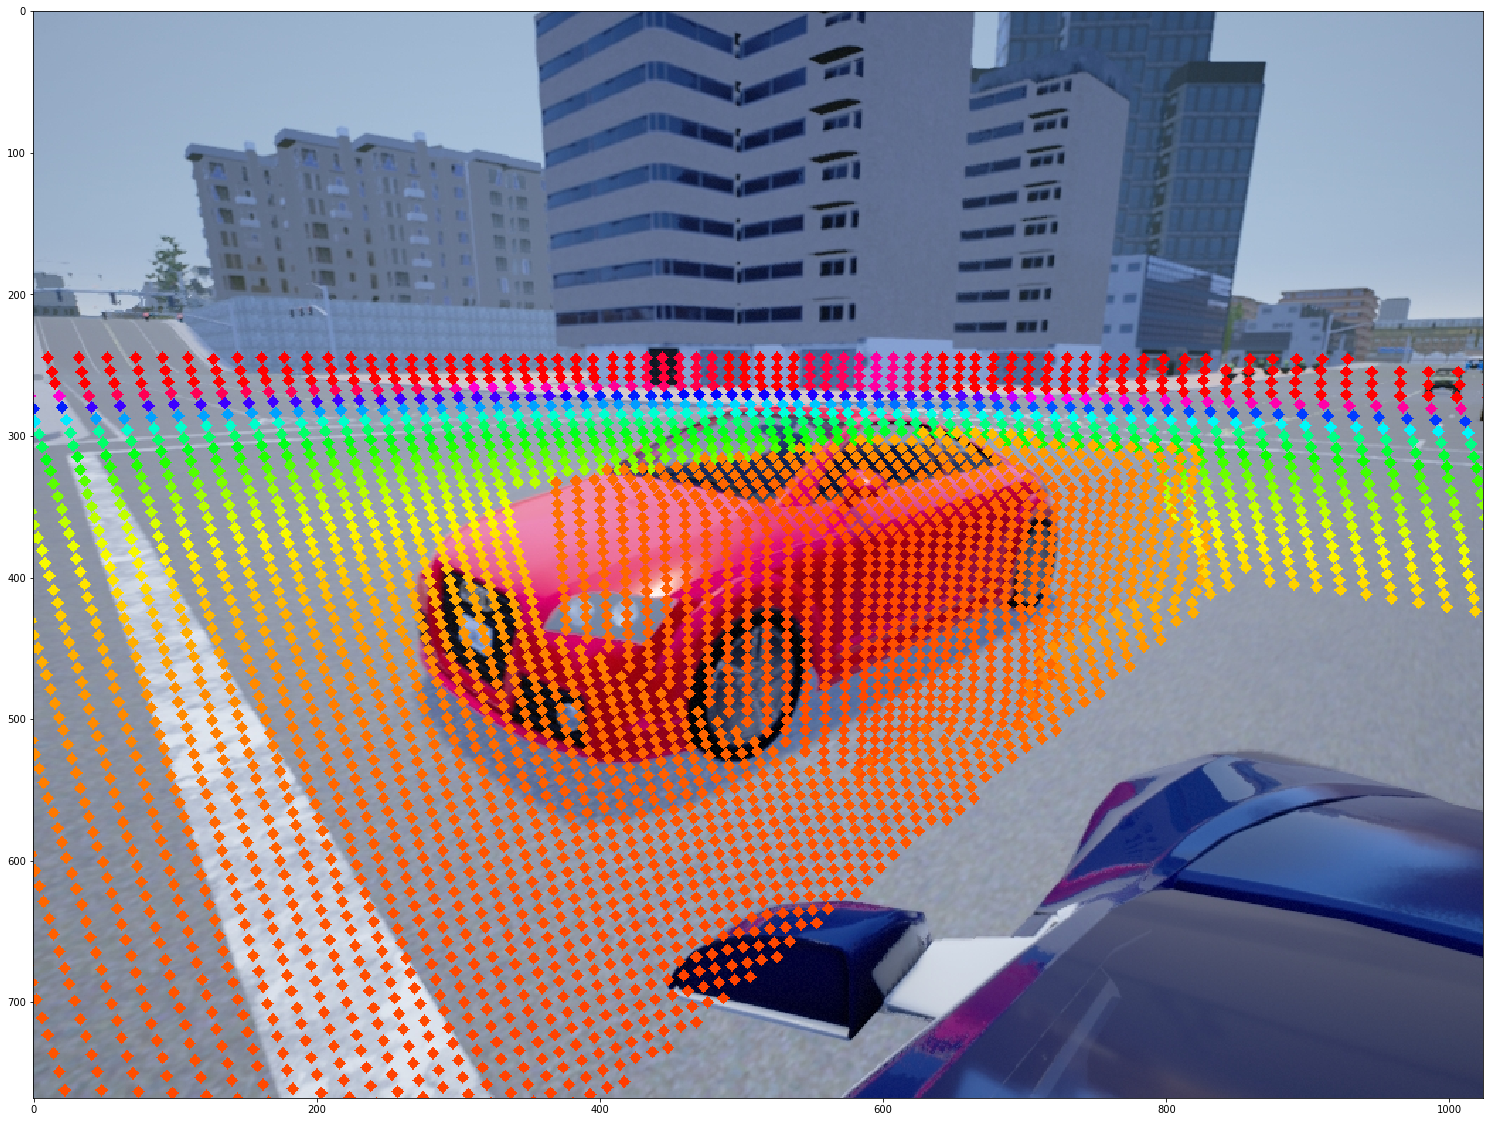

In [467]:
# LIDAR TO CAR:  LIDAR DATA IS ZERO FRAME

T1 = rt_matrix(lidar_transform[0], lidar_transform[1], lidar_transform[2],
               lidar_transform[3]-180, lidar_transform[4], lidar_transform[5]+45*4)

# LIDAR TO VEHICLE LOCATION

T2 = rt_matrix(vehicle_pos[0], vehicle_pos[1], vehicle_pos[2],
               vehicle_pos[3], vehicle_pos[4], vehicle_pos[5])

# COMPOUDING
T3 = np.dot(T2, T1)

extended_pts = np.ones((points.shape[0], 4), dtype=np.float32)
extended_pts[:, :3] = points.copy()

# WORLD COORDINATE

extended_pts = np.dot(T3, extended_pts.T)


# CAMERA SENSOR TO VEHICLE

T1 = rt_matrix(camera_transform[0], camera_transform[1], camera_transform[2],
               camera_transform[3], camera_transform[4], camera_transform[5])

# SENSOR TO WORLD
T2 = rt_matrix(vehicle_pos[0], vehicle_pos[1], vehicle_pos[2],
               vehicle_pos[3], vehicle_pos[4], vehicle_pos[5])

# COMPOUDING 
T3 = np.dot(T2, T1)

# GETTING THE INVERSE TRANSFORMATION
T4 = np.linalg.inv(T3)


pts_camera = np.dot(T4, extended_pts)[:3, :]

calibration = np.identity(3)
calibration[0, 2] = 1024.0 / 2.0
calibration[1, 2] = 768.0 / 2.0
calibration[0, 0] = calibration[1, 1] = 1024 / (2.0 * np.tan(90.0 * np.pi / 360.0))

cords_y_minus_z_x = np.concatenate([pts_camera[1, :], -pts_camera[2, :], pts_camera[0, :]])
pts = np.transpose(np.dot(calibration, cords_y_minus_z_x))
camera_pts = np.concatenate([pts[:, 0] / pts[:, 2], pts[:, 1] / pts[:, 2], pts[:, 2]], axis=1)


# create colormap
color_map = cv2.applyColorMap(np.arange(0, 256, dtype=np.uint8).reshape((1, -1)), cv2.COLORMAP_HSV).reshape((-1, 3))

# distance between the car and camera must be grater than 2.5 meters
dist_mask = LA.norm(points, axis=1)
crop_dist = dist_mask > 1

dist = LA.norm(pts_camera.T, axis=1)

camera_pts = camera_pts[crop_dist, :]
dist = dist[crop_dist]

dist[dist > 50] = 50
dist /= 50
dist *= 255
pcolors = color_map[dist.astype(np.uint8)]

def draw_points3(image, points, data_colors):      
        print('draw points', data_colors.shape)
        for i in range(points.shape[0]):
            if points[i, 2] > 0:
                cor = (int(data_colors[i, 0]), int(data_colors[i, 1]), int(data_colors[i, 2]))
                cv2.circle(image, (int(1024-points[i, 0]), int(points[i, 1])), 2, cor, 4)
        return image

print(camera_pts.shape)
image_lidar = draw_points3(np.zeros_like(image.copy()), camera_pts, pcolors)
image_lidar = draw_points3(image.copy(), camera_pts, pcolors)

plt.imshow(image_lidar[:,:,::-1])
plt.rcParams['figure.figsize'] = [40, 20]
plt.show()

In [468]:
reader = None